<a href="https://colab.research.google.com/github/LuluW8071/Text-Sentiment-Analysis/blob/main/Text-Sentiment-Analysis-using-BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text-Sentiment-Analysis-using-BERT

In [1]:
!pip install transformers[torch] datasets evaluate seaborn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Load the dataset

>__Note:__</br>
**BERT** (Bidirectional Encoder Representations from Transformers) can indeed be trained on a relatively small dataset to yield improved results for certain tasks, especially when fine-tuning a pre-trained model, due to its powerful architecture. It is already pre-trained on larger datasets, possesses powerful contextual understanding, and benefits from effective regularization techniques such as dropout and attention mechanisms, which help prevent overfitting.

>So, we can just take just `20000` datasets and train the **BERT** Model on it for our purpose.

In [2]:
import random
import pandas as pd
import numpy as np

sentiment_to_int = {
	"positive": 2,
	"neutral": 1,
	"negative": 0
}

int_to_sentiment = {
	2: "positive",
	1: "neutral",
	0: "negative"
}

# Reduce to 10000 samples if you want your model to train faster (while loss may increase)
samples = 20000

# Read dataset and take random 20000 samples
df = pd.read_csv("dataset.csv")
df = df.sample(n=samples, random_state=random.randint(0, 100))

# Reset the index
df.reset_index(drop=True, inplace=True)
df.head(), df.shape, df["language"].value_counts()[:5],df["label"].value_counts()

(                                                text language     label
 0                          @qTinaa___ The lost child       en  negative
 1  @aspiringpeasant Well, that's not completely t...       en  positive
 2  @ProjectLincoln “Tony described him as being v...       en  positive
 3  @ferashatoum Hadley Gamble gets to interview l...       en   neutral
 4  @RepMTG Will you MTG, go to the hearings &amp;...       en   neutral,
 (20000, 3),
 language
 en    18614
 fr      257
 es      250
 pt      218
 ja      187
 Name: count, dtype: int64,
 label
 neutral     8786
 positive    5668
 negative    5546
 Name: count, dtype: int64)

In [3]:
df['text'][0]

'@qTinaa___ The lost child'

In [4]:
df['label'].value_counts()

label
neutral     8786
positive    5668
negative    5546
Name: count, dtype: int64

## 2. Text Pre-Processing

- Cleaning up the text data by removing punctuation, extra spaces, and numbers.
- Transform sentences into individual words, remove common words (known as "stop words")

In [5]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter

# Precompile regular expressions for faster pre processing
non_word_chars_pattern = re.compile(r"[^\w\s]")
whitespace_pattern = re.compile(r"\s+")
digits_pattern = re.compile(r"\d")
username_pattern = re.compile(r"@([^\s]+)")
hashtags_pattern = re.compile(r"#\d+")
br_pattern = re.compile(r'<br\s*/?>\s*<br\s*/?>')

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = non_word_chars_pattern.sub('', s)
    # Replace all runs of whitespaces with single space
    s = whitespace_pattern.sub(' ', s)
    # Replace digits with no space
    s = digits_pattern.sub('', s)
    # Replace usernames with no space
    s = username_pattern.sub('', s)
    # Replace hashtags with no space
    s = hashtags_pattern.sub('', s)
    # Replace <br /> pattern with empty string
    s = br_pattern.sub('', s)
    # Replace specific characters
    s = s.replace("https", "")
    s = s.replace("http", "")
    s = s.replace("rt", "")
    s = s.replace("-", "")
    # Replace br with empty string
    s = s.replace("br", "")
    # Replace newline character with empty string
    s = s.replace("\n", "")
    return s

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mk473\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from tqdm.notebook import tqdm_notebook

preprocessed_reviews = []

# Apply preprocessing
for review in tqdm_notebook(df['text'], desc='Preprocessing'):
    preprocessed_review = preprocess_string(review)
    preprocessed_reviews.append(preprocessed_review)

# Assign the preprocessed reviews back to  'review' column
df['text'] = preprocessed_reviews

Preprocessing:   0%|          | 0/20000 [00:00<?, ?it/s]

In [7]:
df['text'][0], df['label'][0]

('qTinaa___ The lost child', 'negative')

## 3. Mapping `sentiment` column to numeric values

In [8]:
# Map 'positive' to 1 & 'negative' to 0
df['label'] = df['label'].replace(sentiment_to_int)
df.head()

C:\Users\mk473\AppData\Local\Temp\ipykernel_23172\314817569.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace(sentiment_to_int)


,text,language,label
0,qTinaa___ The lost child,en,0
1,aspiringpeasant Well thats not completely true...,en,2
2,ProjectLincoln Tony described him as being ver...,en,2
3,ferashatoum Hadley Gamble gets to interview le...,en,1
4,RepMTG Will you MTG go to the hearings amp tes...,en,1


## 4. Spliiting datasets into train and test

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['label'],
                                                    test_size=0.2)

len(X_train), len(X_test)

(16000, 4000)

In [10]:
X_train, X_test, y_train, y_test = list(X_train), list(X_test), list(y_train), list(y_test)
X_train[:2], y_train[:2]

(['I was thinking about this earlier it seems odd that all the focus is on Clarence dont get me wrong fuck that dude but like what about the other like  or  ppl tcovEPChSuTTb',
  'wow sir that was a bad good morning greeting'],
 [0, 0])

## 5. Preparing data using custom dataloader

In [11]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

# Setting device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [12]:
class data(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, index):
    item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[index])
    return item

  def __len__(self):
    return len(self.labels)

## 6. Load PreTrained BERT Model

**BERT** (Bidirectional Encoder Representations from Transformers) is a pre-trained language representation model developed by researchers at Google.

<img src = "https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Attention_diagram_transformer.png?ssl=1">

- BERT architecture consists of `multiple encoder transformer blocks` stacked together.
- Each transformer block includes` multi-head self-attention` and `feed-forward neural networks`.
- `Multi-head self-attention` allows BERT to weigh word importance based on context, capturing long-range dependencies effectively.
- The output from `attention mechanisms` undergoes non-linear transformations via `feed-forward neural networks`.
- `Layer normalization` and `residual connections` stabilize training and facilitate gradient flow within each transformer block.
- `Positional encodings` preserve word order in sequences, aiding BERT in understanding the sequential nature of data.

>BERT is pre-trained on a large text corpus using tasks like masked language modeling and next sentence prediction. Fine-tuning on specific tasks involves adjusting the final layers of the pre-trained BERT model.

### [Explanation Video on BERT](https://www.youtube.com/watch?v=6ahxPTLZxU8)

In [13]:
from huggingface_hub import notebook_login

# Paste hugging face token with write permission enabled and log in
notebook_login()

In [14]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

c:\Users\mk473\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## 7. Tokenize and Create Encoded Dataset

In [15]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)

# Tokenize with truncation and padding and create dataset from tokenized data
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

train_dataset = data(train_encoding, y_train)
test_dataset = data(test_encoding, y_test)

## 8. Fine-Tuning Distil BERT

Fine-tuning BERT, a pre-trained language model, allows us to adapt it to specific NLP tasks such as text classification, named entity recognition, sentiment analysis, and question answering.


<img src = "https://raw.githubusercontent.com/LuluW8071/Text-Sentiment-Analysis/dfa065d8169ae9d26460114e612118f5628d7dd3//assets/BERT-Fine-tuning-pipeline.png">

In [16]:
batch_size = 2

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-sentiment",
    num_train_epochs=1,                              # No of epochs to train
    per_device_train_batch_size=batch_size,          # Batch size for training per device
    per_device_eval_batch_size=batch_size,           # Batch size for evaluation per device
    learning_rate=2e-5,                              # Learning rate for optimizer
    warmup_steps=400,                                # No of warmup steps for the learning rate scheduler
    weight_decay=0.01,                               # Weight decay coefficient for regularization
    logging_dir='./logs',                            # Directory for logging training information
    load_best_model_at_end=True,                     # Whether to load the best model from checkpoints at the end of training
    logging_steps=400,                               # Log training metrics every `logging_steps` steps
    save_steps=400,                                  # Save model checkpoints every `save_steps` steps
    save_total_limit=2,                              # Save no of checkpoints
    evaluation_strategy = "steps",                   # When to run evaluation during training: steps, epochs or none
    fp16=True,                                       # Floating point 16 precision
    push_to_hub=True,                                # Save checkpoint in Hugging Face Hub
    report_to="tensorboard",                         # Enable TensorBoard integration
)


## 9. Train the Fine-Tuned BERT Model

In [17]:
from evaluate import load

accuracy_metric = load("accuracy")

# Compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return accuracy

In [18]:
model = DistilBertForSequenceClassification.from_pretrained(model_name,
                                                            num_labels=3)

# Override the model configuration for custom labels
model.config.id2label = int_to_sentiment
model.config.label2id = {v: k for k, v in int_to_sentiment.items()}


trainer = Trainer(
    model=model,                      # The instantiated Transformers model to be trained
    args=training_args,               # Training arguments, defined above
    train_dataset=train_dataset,      # Training dataset
    eval_dataset=test_dataset,        # Evaluation dataset
    tokenizer=tokenizer,              # Tokenizer
    data_collator=data_collator,      # Data collator
    compute_metrics=compute_metrics,  # Function to compute metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
from accelerate import Accelerator

# Initialize Accelerator and Trainer
Accelerator()
trainer.train()

  0%|          | 0/8000 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 1.0269, 'learning_rate': 1.9900000000000003e-05, 'epoch': 0.05}


  0%|          | 0/2000 [00:00<?, ?it/s]

Checkpoint destination directory distilbert-base-uncased-finetuned-sentiment\checkpoint-400 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6770095229148865, 'eval_accuracy': 0.74375, 'eval_runtime': 23.0622, 'eval_samples_per_second': 173.444, 'eval_steps_per_second': 86.722, 'epoch': 0.05}
{'loss': 0.5296, 'learning_rate': 1.8960526315789475e-05, 'epoch': 0.1}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.4745621979236603, 'eval_accuracy': 0.90025, 'eval_runtime': 24.1085, 'eval_samples_per_second': 165.917, 'eval_steps_per_second': 82.958, 'epoch': 0.1}
{'loss': 0.3802, 'learning_rate': 1.7910526315789477e-05, 'epoch': 0.15}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.40361708402633667, 'eval_accuracy': 0.91825, 'eval_runtime': 24.4339, 'eval_samples_per_second': 163.707, 'eval_steps_per_second': 81.854, 'epoch': 0.15}
{'loss': 0.3696, 'learning_rate': 1.6857894736842106e-05, 'epoch': 0.2}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.332944393157959, 'eval_accuracy': 0.9345, 'eval_runtime': 22.7312, 'eval_samples_per_second': 175.969, 'eval_steps_per_second': 87.985, 'epoch': 0.2}
{'loss': 0.2255, 'learning_rate': 1.580526315789474e-05, 'epoch': 0.25}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.2242332547903061, 'eval_accuracy': 0.95525, 'eval_runtime': 22.7715, 'eval_samples_per_second': 175.658, 'eval_steps_per_second': 87.829, 'epoch': 0.25}
{'loss': 0.1835, 'learning_rate': 1.475263157894737e-05, 'epoch': 0.3}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.20933668315410614, 'eval_accuracy': 0.95825, 'eval_runtime': 22.4997, 'eval_samples_per_second': 177.78, 'eval_steps_per_second': 88.89, 'epoch': 0.3}
{'loss': 0.1795, 'learning_rate': 1.3700000000000003e-05, 'epoch': 0.35}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.1944439709186554, 'eval_accuracy': 0.96025, 'eval_runtime': 22.5373, 'eval_samples_per_second': 177.483, 'eval_steps_per_second': 88.742, 'epoch': 0.35}
{'loss': 0.2302, 'learning_rate': 1.2647368421052632e-05, 'epoch': 0.4}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.20657482743263245, 'eval_accuracy': 0.9575, 'eval_runtime': 23.1407, 'eval_samples_per_second': 172.856, 'eval_steps_per_second': 86.428, 'epoch': 0.4}
{'loss': 0.1684, 'learning_rate': 1.1594736842105263e-05, 'epoch': 0.45}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.22517213225364685, 'eval_accuracy': 0.95875, 'eval_runtime': 22.8098, 'eval_samples_per_second': 175.363, 'eval_steps_per_second': 87.682, 'epoch': 0.45}
{'loss': 0.193, 'learning_rate': 1.0542105263157896e-05, 'epoch': 0.5}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.20907127857208252, 'eval_accuracy': 0.96125, 'eval_runtime': 22.7618, 'eval_samples_per_second': 175.733, 'eval_steps_per_second': 87.867, 'epoch': 0.5}
{'loss': 0.1635, 'learning_rate': 9.489473684210527e-06, 'epoch': 0.55}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.21658754348754883, 'eval_accuracy': 0.959, 'eval_runtime': 22.7837, 'eval_samples_per_second': 175.564, 'eval_steps_per_second': 87.782, 'epoch': 0.55}
{'loss': 0.1854, 'learning_rate': 8.43684210526316e-06, 'epoch': 0.6}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.18169012665748596, 'eval_accuracy': 0.963, 'eval_runtime': 22.8133, 'eval_samples_per_second': 175.337, 'eval_steps_per_second': 87.668, 'epoch': 0.6}
{'loss': 0.1927, 'learning_rate': 7.386842105263159e-06, 'epoch': 0.65}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.15522322058677673, 'eval_accuracy': 0.9635, 'eval_runtime': 22.6217, 'eval_samples_per_second': 176.821, 'eval_steps_per_second': 88.411, 'epoch': 0.65}
{'loss': 0.1589, 'learning_rate': 6.3342105263157905e-06, 'epoch': 0.7}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.14635467529296875, 'eval_accuracy': 0.963, 'eval_runtime': 22.7701, 'eval_samples_per_second': 175.669, 'eval_steps_per_second': 87.834, 'epoch': 0.7}
{'loss': 0.1078, 'learning_rate': 5.2842105263157896e-06, 'epoch': 0.75}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.1756427139043808, 'eval_accuracy': 0.9625, 'eval_runtime': 22.6829, 'eval_samples_per_second': 176.344, 'eval_steps_per_second': 88.172, 'epoch': 0.75}
{'loss': 0.1808, 'learning_rate': 4.2315789473684215e-06, 'epoch': 0.8}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.17171846330165863, 'eval_accuracy': 0.96075, 'eval_runtime': 22.8612, 'eval_samples_per_second': 174.969, 'eval_steps_per_second': 87.484, 'epoch': 0.8}
{'loss': 0.1185, 'learning_rate': 3.178947368421053e-06, 'epoch': 0.85}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.14037279784679413, 'eval_accuracy': 0.96575, 'eval_runtime': 23.0891, 'eval_samples_per_second': 173.242, 'eval_steps_per_second': 86.621, 'epoch': 0.85}
{'loss': 0.1526, 'learning_rate': 2.1263157894736844e-06, 'epoch': 0.9}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.12886404991149902, 'eval_accuracy': 0.96825, 'eval_runtime': 23.6595, 'eval_samples_per_second': 169.065, 'eval_steps_per_second': 84.533, 'epoch': 0.9}
{'loss': 0.1036, 'learning_rate': 1.0736842105263159e-06, 'epoch': 0.95}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.13762177526950836, 'eval_accuracy': 0.967, 'eval_runtime': 23.765, 'eval_samples_per_second': 168.315, 'eval_steps_per_second': 84.157, 'epoch': 0.95}
{'loss': 0.1551, 'learning_rate': 2.1052631578947368e-08, 'epoch': 1.0}


  0%|          | 0/2000 [00:00<?, ?it/s]

{'eval_loss': 0.13632120192050934, 'eval_accuracy': 0.967, 'eval_runtime': 22.7852, 'eval_samples_per_second': 175.552, 'eval_steps_per_second': 87.776, 'epoch': 1.0}
{'train_runtime': 866.7214, 'train_samples_per_second': 18.46, 'train_steps_per_second': 9.23, 'train_loss': 0.2502633867263794, 'epoch': 1.0}


TrainOutput(global_step=8000, training_loss=0.2502633867263794, metrics={'train_runtime': 866.7214, 'train_samples_per_second': 18.46, 'train_steps_per_second': 9.23, 'train_loss': 0.2502633867263794, 'epoch': 1.0})

## 10. Sentiment Prediction using custom text


In [20]:
# Tokenize text, get output from model and predict
def predict_sentiment(model, tokenizer, text, device):
    tokenized = tokenizer(text, truncation=True, padding=True, return_tensors='pt').to(device)
    outputs = model(**tokenized)

    probs = F.softmax(outputs.logits, dim=-1)
    preds = torch.argmax(outputs.logits, dim=-1).item()
    probs_max = probs.max().detach().cpu().numpy()

    prediction = int_to_sentiment[preds]
    print(f'{text}\nSentiment: {prediction}\tProbability: {probs_max*100:.2f}%\n', end="-"*50 + "\n")
    # return prediction, probs_max

In [21]:
texts = [
    "The traffic was horrendous this morning; I was stuck in it for over an hour.",
    "I was extremely disappointed with the quality of the product; it didn't meet my expectations at all.",
    "The customer service at the restaurant was very good; the staff went above and beyond to make us feel welcome.",
    "My recent stay at Paradise Resort was absolutely fantastic! From the moment I arrived, I was greeted with warm smiles and excellent service. The room was spacious, beautifully decorated, and spotlessly clean. I loved the breathtaking view from my balcony overlooking the pool and tropical gardens. The dining options were exceptional, and the resort's facilities were top-notch, offering everything from a fitness center to guided nature walks. Overall, Paradise Resort exceeded all my expectations, and I can't wait to return for another memorable stay!",
    "The movie started off promising, but it quickly went downhill. The plot was confusing, the acting was mediocre, and the ending was unsatisfying.",
    "I had a terrible experience at the restaurant last night. The food was cold, the service was slow, and the staff was rude.",
    "Despite the initial skepticism, I was pleasantly surprised by the performance of the new smartphone. Its sleek design, impressive camera quality, and fast processing speed exceeded my expectations.",
    "The concert was absolutely amazing! The energy of the performers, the enthusiasm of the crowd, and the quality of the music made it an unforgettable experience.",
    "I had high hopes for the book, but it turned out to be a disappointment. The characters were one-dimensional, the plot was predictable, and the writing style was uninspired.",
    "The presentation was well-prepared and delivered with confidence. The speaker engaged the audience effectively and provided valuable insights on the topic.",
    "The service at the hotel was impeccable. The staff was attentive, courteous, and always willing to assist with any request.",
    "The weather during our vacation was dreadful; it rained every day, and we were stuck indoors for most of the trip.",
    "The hiking trail offered breathtaking views of the mountains and lush forests. It was a challenging but rewarding experience.",
    "The customer support team was unhelpful and incompetent. They were unable to resolve my issue and seemed indifferent to my concerns.",
    "The play was a delightful blend of humor, drama, and suspense. The talented cast delivered stellar performances, and the storyline kept me engaged from start to finish.",
    "The new restaurant in town has quickly become my favorite dining spot. The food is delicious, the atmosphere is cozy, and the service is outstanding.",
]

for text in texts:
  predict_sentiment(model, tokenizer, text, device)

The traffic was horrendous this morning; I was stuck in it for over an hour.
Sentiment: negative	Probability: 54.37%
--------------------------------------------------
I was extremely disappointed with the quality of the product; it didn't meet my expectations at all.
Sentiment: negative	Probability: 99.92%
--------------------------------------------------
The customer service at the restaurant was very good; the staff went above and beyond to make us feel welcome.
Sentiment: positive	Probability: 99.96%
--------------------------------------------------
My recent stay at Paradise Resort was absolutely fantastic! From the moment I arrived, I was greeted with warm smiles and excellent service. The room was spacious, beautifully decorated, and spotlessly clean. I loved the breathtaking view from my balcony overlooking the pool and tropical gardens. The dining options were exceptional, and the resort's facilities were top-notch, offering everything from a fitness center to guided nature 

In [22]:
# An example of complex review that contains both positive and negative sentiment
texts = ["Despite facing numerous challenges and setbacks, the team worked tirelessly and managed to exceed all expectations, achieving remarkable success. However, despite their best efforts, the project encountered multiple setbacks, ultimately leading to its failure and significant financial losses.",
         "The hotel room was clean and comfortable, and the amenities were well-maintained. However, the noise from the nearby construction site was disruptive due to which i could not focus when working.",
         "The movie had an intriguing plot and captivating visuals, but the sound quality was poor, making it difficult to fully enjoy the experience."]
for text in texts:
  predict_sentiment(model, tokenizer, text, device)

Despite facing numerous challenges and setbacks, the team worked tirelessly and managed to exceed all expectations, achieving remarkable success. However, despite their best efforts, the project encountered multiple setbacks, ultimately leading to its failure and significant financial losses.
Sentiment: positive	Probability: 99.93%
--------------------------------------------------
The hotel room was clean and comfortable, and the amenities were well-maintained. However, the noise from the nearby construction site was disruptive due to which i could not focus when working.
Sentiment: neutral	Probability: 59.47%
--------------------------------------------------
The movie had an intriguing plot and captivating visuals, but the sound quality was poor, making it difficult to fully enjoy the experience.
Sentiment: negative	Probability: 99.96%
--------------------------------------------------


In [23]:
# Breaking down above example into parts
texts = ["Despite facing numerous challenges and setbacks, the team worked tirelessly and managed to exceed all expectations, achieving remarkable success.",
         "However, despite their best efforts, the project encountered multiple setbacks, ultimately leading to its failure and significant financial losses.",
         "The hotel room was clean and comfortable, and the amenities were well-maintained.",
         "However, the noise from the nearby construction site was disruptive due to which i could not focus when working."]

for text in texts:
  predict_sentiment(model, tokenizer, text, device)

Despite facing numerous challenges and setbacks, the team worked tirelessly and managed to exceed all expectations, achieving remarkable success.
Sentiment: positive	Probability: 99.51%
--------------------------------------------------
However, despite their best efforts, the project encountered multiple setbacks, ultimately leading to its failure and significant financial losses.
Sentiment: positive	Probability: 99.96%
--------------------------------------------------
The hotel room was clean and comfortable, and the amenities were well-maintained.
Sentiment: positive	Probability: 74.40%
--------------------------------------------------
However, the noise from the nearby construction site was disruptive due to which i could not focus when working.
Sentiment: negative	Probability: 71.71%
--------------------------------------------------


Looks like **BERT** can accurately interpret the overall sentiment of the text, recognizing the positive aspects (clean and comfortable room, well-maintained amenities) as well as the negative aspect (disruptive noise from construction). By considering the context and weighing the various sentiments present, BERT can provide a nuanced understanding of the text's sentiment.

Overall, BERT's capability to handle mixed sentiments reflects its robustness and versatility in natural language understanding, making it a valuable tool for sentiment analysis and various other NLP tasks.

## 11. Evaluate & Plot Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
# Predict X_test dataset and evaluate through usage of metrics and
# plot Confusion Matrix
def predict_sentiment_and_evaluate(model, tokenizer, X_test, y_test, device):
  predictions = []

  for text in tqdm(X_test):
    # Tokenize and forward pass to model
    tokenized = tokenizer(text, truncation=True, padding=True, return_tensors='pt').to(device)
    outputs = model(**tokenized)

    # Inference
    preds = torch.argmax(outputs.logits, dim=-1).item()
    prediction = preds
    predictions.append(prediction)

  # Confusion Matrix
  cm = confusion_matrix(y_test, predictions)
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
              xticklabels=['Negative', 'Neutral', 'Positive'],
              yticklabels=['Negative', 'Neutral', 'Positive'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

  0%|          | 0/4000 [00:00<?, ?it/s]

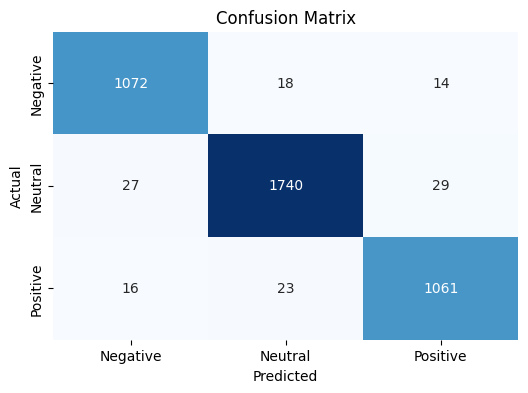

In [28]:
predict_sentiment_and_evaluate(model, tokenizer, X_test, y_test, device)